# Data Loading and Exploration

In [1]:
# Load data.

import pickle
from satml import expression

TRAIN_SPLIT = 0.8
DATA_FILE = 'data/sr_40.pickle'

with open(DATA_FILE, 'rb') as f:
    decisions = pickle.load(f)

assert decisions is not None

# Extract the maximum number of variables.
# TODO(mert): Perhaps don't assume that the dataset is uniform in its set of free variables.
sample_formula, _ = decisions[0]
vocab_size = len(expression.free(sample_formula))

print("Loaded {} decisions".format(len(decisions)))

Loaded 9519 decisions


Since there's no meaning to variable "names", and LSTMs will later try to assign some meaning to them, we're going to normalize them. The first variable we see is going to be `1`, second `2`, and so on.

In [2]:
def normalize_dataset(decisions):
    norm_decisions = []
    
    for formula, (var, assignment) in decisions:
        var_map = {}
        formula = expression.rename(formula, var_map=var_map)
        
        norm_decisions.append((formula, (var_map[var], assignment)))
        
    return norm_decisions
        
decisions = normalize_dataset(decisions)

Let's take a look at the normalized dataset.

In [3]:
for formula, (var, assignment) in decisions[:3]:
    print("{} = {} in formula: {}".format(var, assignment, expression.pprint(formula)))

24 = False in formula: ((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((-1 ∨ (-2 ∨ (-3 ∨ (-4 ∨ (5 ∨ 6))))) ∧ (-7 ∨ (-8 ∨ (-9 ∨ (10 ∨ (-11 ∨ -12)))))) ∧ (-13 ∨ (-14 ∨ (-15 ∨ (6 ∨ (16 ∨ 3)))))) ∧ (1 ∨ (17 ∨ (18 ∨ 19)))) ∧ (-4 ∨ (-20 ∨ (-5 ∨ (21 ∨ (13 ∨ (-1 ∨ (-11 ∨ (-15 ∨ (-9 ∨ -22)))))))))) ∧ (-13 ∨ (-23 ∨ -24))) ∧ (-25 ∨ (17 ∨ (10 ∨ (-3 ∨ (-26 ∨ (-27 ∨ (28 ∨ -29)))))))) ∧ (-30 ∨ 9)) ∧ (31 ∨ (16 ∨ 11))) ∧ (32 ∨ (29 ∨ 18))) ∧ (33 ∨ (34 ∨ (-35 ∨ 3)))) ∧ (-19 ∨ 26)) ∧ (-17 ∨ (-36 ∨ (11 ∨ 35)))) ∧ (-3 ∨ (-32 ∨ (-37 ∨ 20)))) ∧ (-10 ∨ (-38 ∨ (32 ∨ (-26 ∨ -7))))) ∧ (-37 ∨ (2 ∨ (-23 ∨ 18)))) ∧ (-3 ∨ (-35 ∨ 17))) ∧ (-16 ∨ (9 ∨ (-12 ∨ 19)))) ∧ (-32 ∨ (-38 ∨ -35))) ∧ (-15 ∨ (19 ∨ (14 ∨ -27)))) ∧ (12 ∨ (29 ∨ (-34 ∨ (6 ∨ (17 ∨ (-36 ∨ -39))))))) ∧ (-30 ∨ (26 ∨ 25))) ∧ (21 ∨ (20 ∨ -2))) ∧ (1 ∨ (25 ∨ -4))) ∧ (19 ∨ (3 ∨ -40))) ∧ (-4 ∨ (18 ∨ (19 ∨ (15 ∨ (-25 ∨ (-12 ∨ (17 ∨ 

In [4]:
# Split into training/test sets.
num_training = int(len(decisions) * TRAIN_SPLIT)
decisions_training, decisions_test = decisions[:num_training], decisions[num_training:]

Let's look at how the approximate optimal heuristic is distributed. We're expecting a roughly uniform distribution over variable names, as variables are initially named randomly and our renaming is a bijection, preserving its randomness.

In [5]:
import numpy as np

picked_vars, picked_assignments = zip(*((int(var), int(assignment)) for _, (var, assignment) in decisions))
picked_vars, picked_assignments = np.array(picked_vars), np.array(picked_assignments)

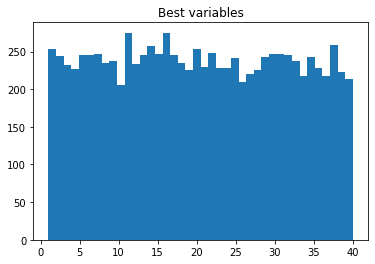

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(picked_vars, vocab_size)
plt.title('Best variables')
plt.show()

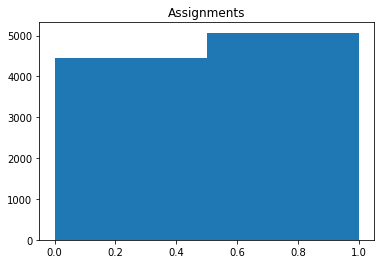

In [7]:
plt.hist(picked_assignments, 2)
plt.title('Assignments')
plt.show()

# Prediction

For the LSTM model, we need to convert our dataset of formulas in AST form into a sequence of tokens. We're going to do some preprocessing:

- We're going to convert variables into one-hot vectors; and connectives into special one-hot tokens.

In [8]:
token_length = vocab_size + 2 # for connectives AND and OR

def one_hot(length: int, index: int):
    element = -1 if index < 0 else 1
    index = abs(index)
    
    v = [0] * length
    v[index] = element
    return v

SPECIAL_TOKENS = {
    expression.Type.AND: one_hot(token_length, vocab_size),
    expression.Type.OR: one_hot(token_length, vocab_size + 1)
}

def tokenize_formula(formula):
    return torch.FloatTensor(_tokenize_formula(formula))

def _tokenize_formula(formula):
    if not formula:
        return []
    
    assert isinstance(formula, expression.Expression)
    
    typ, l_val, r_val = formula

    # We're at a variable, embed it.
    if typ == expression.Type.VAR:
        # Variables are 1-indexed
        zero_idx = int(l_val) - 1
        return [one_hot(token_length, zero_idx)]
    # We're at a NOT'd variable, reach one level below and embed it.
    if typ == expression.Type.NOT:
        assert l_val.typ == expression.Type.VAR, "Expecting negations to be propagated to literal level"
        zero_idx = int(l_val.l_val) - 1
        return [one_hot(token_length, -1 * zero_idx)]

    # Else join tokenizations of branches into one sequence
    return _tokenize_formula(l_val) + [SPECIAL_TOKENS[typ]] + _tokenize_formula(r_val)

- Now that we have formula sequences, we must have labels for these formulas. Our formula labels are in $\mathbb{Z} \times \{0, 1\}$, with the first element bounded by `vocab_size`. We're simply going to index into the Cartesian product of these sets.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [10]:
from typing import Tuple, List

label_length = vocab_size * 2

def tokenize_policy(policy: Tuple[int, bool]) -> int:
    """Torch's log-softmax expects ordinal integers as classes, so we do that."""
    idx, branch = policy
    zero_idx = idx - 1
    return zero_idx * 2 + int(branch)

In [11]:
def tokenize_dataset(decisions):
    X, y = zip(*((tokenize_formula(formula), tokenize_policy(policy)) for formula, policy in decisions))
    return X, y

# List of 2D tensors, List of 1D tensors
X_train, y_train = tokenize_dataset(decisions_training)
X_test, y_test = tokenize_dataset(decisions_test)

## LSTM

Now let's try a traditional LSTM approach in predicting this data.

In [17]:
class LSTMDataset(data.Dataset):
    def __init__(self, sequences, labels):
        """Expects a list of 2D tensors (sequences) and a list of vectors (labels)"""
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    
def lstm_collator(batch):
    """Expects `batch` to be a list of (X, y) pairs."""
    X, y = zip(*batch)
    seq_lens = torch.tensor([len(seq) for seq in X])
    padded_sequences = nn.utils.rnn.pad_sequence(X, batch_first=True)
    packed_batch = nn.utils.rnn.pack_padded_sequence(
        padded_sequences,
        seq_lens,
        batch_first=True,
        enforce_sorted=False
    )
    
    return packed_batch, torch.LongTensor(y)

dataset_train = LSTMDataset(X_train, y_train)
dataset_test = LSTMDataset(X_test, y_test)

loader_opts = {
    'collate_fn': lstm_collator,
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 4
}

loader_train = data.DataLoader(dataset=dataset_train, **loader_opts)
loader_test = data.DataLoader(dataset=dataset_test, **loader_opts)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, linear_dims: List[int], num_lstm_layers: int):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_lstm_layers, batch_first=True)
        
        input_dims = [self.hidden_dim] + linear_dims[:-1]
        self.linears = [nn.Linear(input, output) for input, output in zip(input_dims, linear_dims)]
        
    def forward(self, packed_input):
        """Expects a packed sequence."""
        _, (hidden, _) = self.lstm(packed_input)
        x = hidden[-1]
        
        for linear in self.linears:
            x = linear(x)
            
        return x

Let's train the model.

In [18]:
model = LSTM(
    input_dim=token_length,
    hidden_dim=5,
    linear_dims=[8, label_length],
    num_lstm_layers=1
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters()) # Use the default LR schedule

EPOCHS = 300
print_every = 50
running_loss, running_accuracy = 0, 0

for t in range(EPOCHS):
    for step, (X, y) in enumerate(loader_train):
        model.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            class_predictions = y_pred.max(1)[1]            
            num_accurate = class_predictions.eq(y).sum()
            
            running_loss += (loss.item() / print_every)
            running_accuracy += (float(num_accurate) / (y.shape[0] * print_every))
        
            if step % print_every == 0:
                print(f"Epoch {t + 1}/{EPOCHS} "
                      f"Step {step + 1}/{len(loader_train)} "
                      f"Train loss: {running_loss} "
                      f"Train acc: {running_accuracy}")
                running_loss, running_accuracy = 0, 0

Epoch 1/300 Step 1/119 Train loss: 0.08785226821899414 Train acc: 0.0


KeyboardInterrupt: 